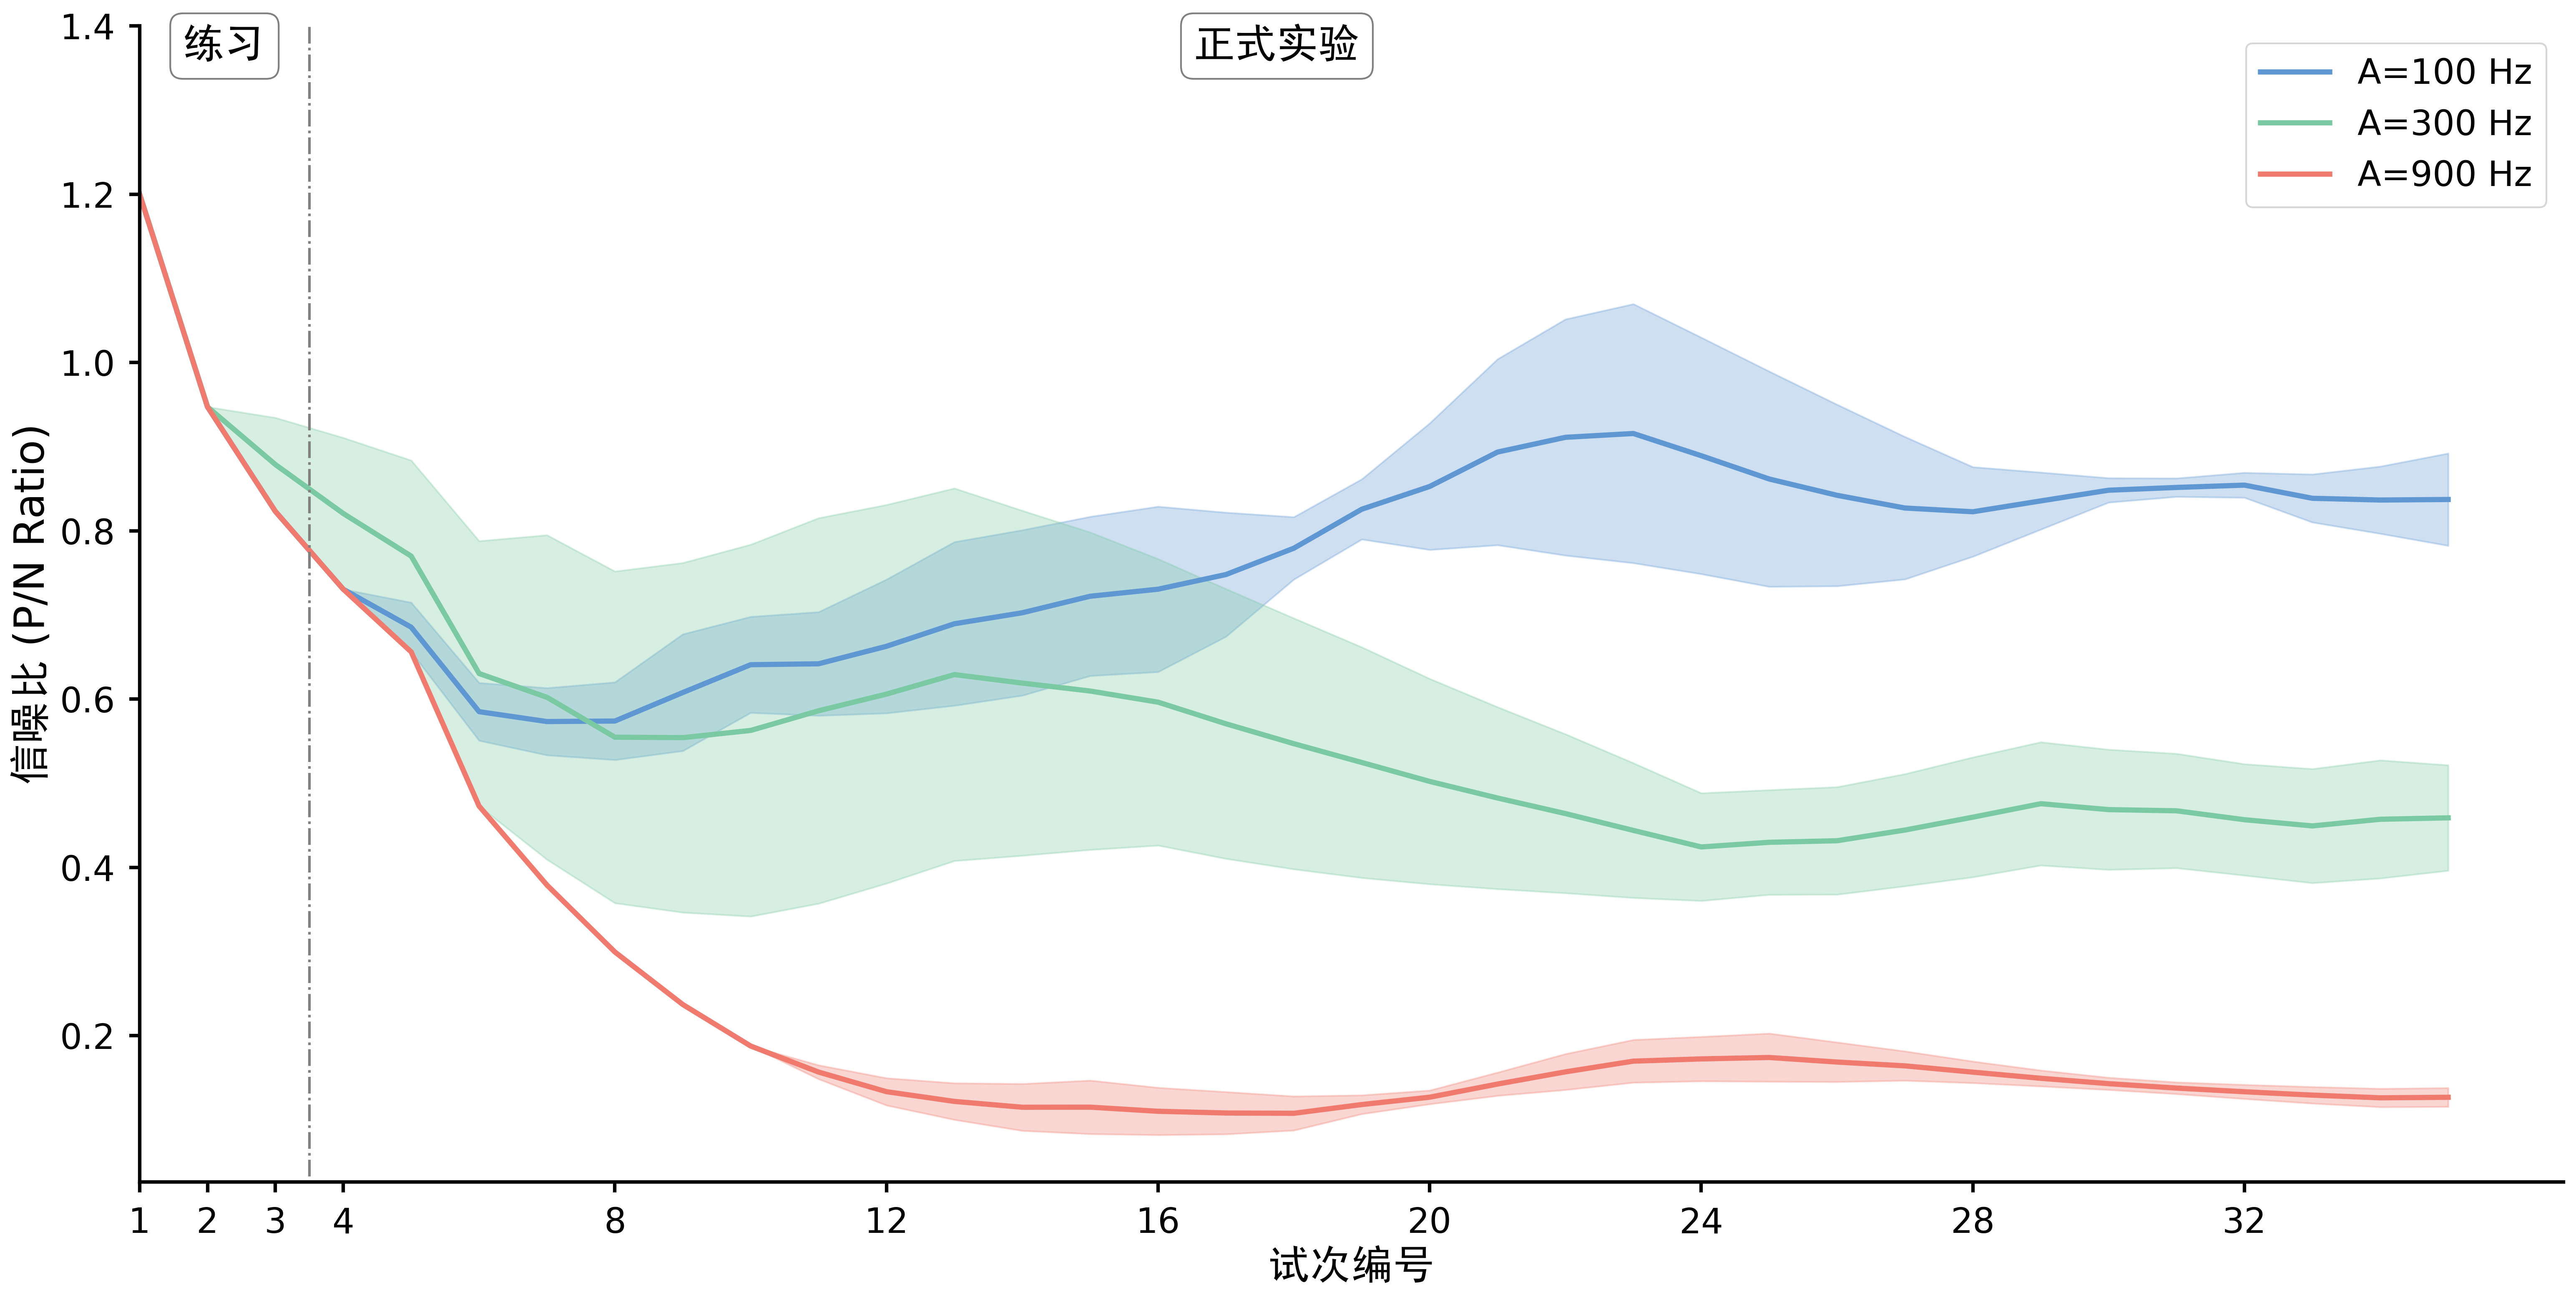

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['font.family'] = ['DejaVu Sans', 'SimHei']
plt.rcParams['font.size'] = 20
plt.rcParams['figure.dpi'] = 300
axis_linewidth = 2

csv_files = []
dirname = 'data_exp2'
for files in os.listdir(os.path.join(os.getcwd(),dirname)):
    if files.endswith('.csv'):
        csv_files.append(os.path.join(dirname, files))
# First, load all the subject data
all_subjects_data = []
for csv_file in csv_files:
    # Read data
    df_subject = pd.read_csv(csv_file, header=0)
    practise_trials = 0
    df_subject = df_subject[df_subject['trial_overall'] > practise_trials]
    all_subjects_data.append(df_subject)

# Group by A_value_Hz for averaging across subjects
A_values = []
for df_subject in all_subjects_data:
    A_values.extend(df_subject['A_value_Hz'].unique())
A_values = sorted(list(set(A_values)))  # Unique values

# Create figure
fig = figure(figsize=(25, 12))
condition_colors = {100:'#5F97D2', 300:'#7BC9A3', 900:'#EF7A6D'}
# For each A_value_Hz, average across subjects
for value in A_values:
    # Collect data for this A_value from each subject
    condition_data = []
    for df_subject in all_subjects_data:
        subject_condition_data = df_subject[df_subject['A_value_Hz'] == value]
        if not subject_condition_data.empty:
            condition_data.append(subject_condition_data[['trial_overall', 'presented_pn_ratio']])
    
    if not condition_data:
        continue
    
    # Prepare for averaging
    max_trials = max([len(data) for data in condition_data])
    
    # Calculate moving average and SEM for each trial point
    moving_avgs = []
    moving_sems = []
    window_size = 5  # Default window size
    
    for trial_idx in range(max_trials):
        # Collect all subjects' values for this trial
        trial_values_by_subject = []
        for subject_data in condition_data:
            if trial_idx < len(subject_data):
                if trial_idx < 2:  # First two points
                    # Use available points
                    window_start = 0
                    window_end = trial_idx + 1
                elif trial_idx < window_size - 1:  # Not enough points for full window
                    window_start = 0
                    window_end = trial_idx + 1
                else:  # Full window available
                    window_start = trial_idx - (window_size - 1)
                    window_end = trial_idx + 1
                
                # Get window values for this subject
                window_values = subject_data['presented_pn_ratio'].iloc[window_start:window_end].values
                if len(window_values) > 0:
                    trial_values_by_subject.append(np.mean(window_values))
        
        # Calculate mean and SEM across subjects for this trial
        if trial_values_by_subject:
            moving_avgs.append(np.mean(trial_values_by_subject))
            # Standard error of the mean = std / sqrt(n)
            sem = np.std(trial_values_by_subject, ddof=1) / np.sqrt(len(trial_values_by_subject)) if len(trial_values_by_subject) > 1 else 0
            moving_sems.append(sem)
    
    color = condition_colors[value]
    # Plot moving average with error bands
    x_values = np.arange(1, len(moving_avgs) + 1)
    plt.plot(x_values, moving_avgs, '-', linewidth=3, label=f'A={value} Hz',color = color)
    plt.fill_between(x_values, 
                    np.array(moving_avgs) - np.array(moving_sems), 
                    np.array(moving_avgs) + np.array(moving_sems), 
                    alpha=0.3,color = color)

# Add labels and legend
plt.xlabel('试次编号',fontsize = 24)
plt.ylabel('信噪比 (P/N Ratio)',fontsize = 24)
# plt.title('Moving Average of PN Ratio Across Subjects by A_value_Hz (with SEM)')
ax = plt.gca()
ax.legend(loc='upper right', fontsize=20)
ax.set_xlim(left=1)
ax.set_ylim(top=1.4)
# ax.set_xscale('log')
ax.set_xticks(np.concatenate([np.array([1, 2, 3]), np.linspace(4, 32, endpoint=True, num=8)]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis="both",which = "major",width = axis_linewidth, length = 6,pad = 8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(axis_linewidth)
ax.spines['bottom'].set_linewidth(axis_linewidth)
ax.vlines(3.5,0,1.4,colors='grey',linestyles="-.")
text_ycoor = 1.4
text_xcoor_prac = (3.5+1) /2
text_xcoor_form = (3.5+32)/2
ax.text(s = '练习',x = text_xcoor_prac,y = text_ycoor,
        ha = 'center',va = 'top',fontsize = 24,
        bbox={
            'boxstyle':'round',
            'facecolor':'none',
            'edgecolor':'grey',
            })
ax.text(s = '正式实验',x = text_xcoor_form,y = text_ycoor,
        ha = 'center',va = 'top',fontsize = 24,
        bbox={
            'boxstyle':'round',
            'facecolor':'none',
            'edgecolor':'grey',
            })
plt.savefig('data_exp2/figure_EXP2_BW/questplot.png',dpi = 500,bbox_inches='tight')
plt.show()